In [1]:
import os,shutil

"""GPU设置为按需增长"""
import tensorflow as tf
import keras.backend.tensorflow_backend as KTF
# 指定第一块GPU可用
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"
config = tf.ConfigProto()
config.gpu_options.allow_growth=True   #不全部占满显存, 按需分配
# config.gpu_options.per_process_gpu_memory_fraction = 0.3
sess = tf.Session(config=config)
KTF.set_session(sess)

original_dataset_dir_female = '/home/wangtingshen/tingshen-code/female/'
original_dataset_dir_male = '/home/wangtingshen/tingshen-code/male/'

Using TensorFlow backend.


In [2]:
#保存较小的数据集
base_dir = '/home/wangtingshen/tingshen-code/real-dataset'

#拼接子路径，划分训练、验证、测试集
train_dir = os.path.join(base_dir,'train')
validation_dir = os.path.join(base_dir,'validation')
test_dir = os.path.join(base_dir,'test')

#训练女性图像目录
train_female_dir = os.path.join(train_dir,'female')
#训练男性图像目录
train_male_dir = os.path.join(train_dir,'male')
#验证女性图像目录
validation_female_dir = os.path.join(validation_dir,'female')
#验证男性图像目录
validation_male_dir = os.path.join(validation_dir,'male')
#测试女性图像目录
test_female_dir = os.path.join(test_dir,'female')
#测试男性图像目录
test_male_dir = os.path.join(test_dir,'male')

print('total training female images:',len(os.listdir(train_female_dir)))
print('total training male images:',len(os.listdir(train_male_dir)))
print('total validation female images:',len(os.listdir(validation_female_dir)))
print('total validation male images:',len(os.listdir(validation_male_dir)))
print('total test female images:',len(os.listdir(test_female_dir)))
print('total test male images:',len(os.listdir(test_male_dir)))

total training female images: 70000
total training male images: 70000
total validation female images: 5000
total validation male images: 5000
total test female images: 5000
total test male images: 5000


In [3]:
from keras import models
from keras import layers

In [4]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

#默认打乱数据
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(224,224),
        batch_size=35,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(224,224),
        batch_size=10,
        class_mode='binary')

Found 140000 images belonging to 2 classes.
Found 10000 images belonging to 2 classes.


In [5]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (35, 224, 224, 3)
labels batch shape: (35,)


In [6]:
import keras
from keras.applications.resnet import ResNet50
from keras.models import Sequential
from keras.layers import Dense,Activation,Dropout,Flatten
from keras.layers import Conv2D,MaxPool2D
from keras.utils import plot_model

# 定义输入
input_shape = (224,224,3) # RGB影像224x224（height,width,channel)
#引用模型
conv_base = ResNet50(weights=None, include_top=False, pooling='avg',input_shape=input_shape)
#conv_base.summary()

In [8]:
#定义模型
model = models.Sequential()
# 前馈全连接区块
model.add(conv_base)
model.add(Dense(1,activation='sigmoid',name='predictions'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
predictions (Dense)          (None, 1)                 2049      
Total params: 23,589,761
Trainable params: 23,536,641
Non-trainable params: 53,120
_________________________________________________________________


In [9]:
from keras import optimizers
from keras.callbacks import LearningRateScheduler
import math

def step_decay(epoch):
    initial_lr = 1e-4
    drop = 0.1
    epochs_drop = 15.0
    lrate = initial_lr*math.pow(drop,math.floor((1+epoch)/epochs_drop))
    return lrate

learning_rate = LearningRateScheduler(step_decay)
model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=1e-4), metrics=['acc'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [10]:
history = model.fit_generator(
        train_generator,
        steps_per_epoch=2000, #每个step表示1个batch_size的数据大小
        epochs=100,
        validation_data=validation_generator,
        callbacks=[learning_rate],
        validation_steps=500)


Epoch 1/100
2000/2000 [==============================] - 406s 203ms/step - loss: 0.3086 - acc: 0.8625 - val_loss: 0.0095 - val_acc: 0.9360
Epoch 2/100
2000/2000 [==============================] - 400s 200ms/step - loss: 0.1301 - acc: 0.9487 - val_loss: 0.8380 - val_acc: 0.9340
Epoch 3/100
2000/2000 [==============================] - 404s 202ms/step - loss: 0.0949 - acc: 0.9639 - val_loss: 0.0691 - val_acc: 0.9534
Epoch 4/100
2000/2000 [==============================] - 405s 202ms/step - loss: 0.0832 - acc: 0.9690 - val_loss: 0.1749 - val_acc: 0.9306
Epoch 5/100
2000/2000 [==============================] - 409s 204ms/step - loss: 0.0666 - acc: 0.9755 - val_loss: 0.2418 - val_acc: 0.9578
Epoch 6/100
2000/2000 [==============================] - 412s 206ms/step - loss: 0.0654 - acc: 0.9762 - val_loss: 0.4179 - val_acc: 0.9638
Epoch 7/100
2000/2000 [==============================] - 411s 206ms/step - loss: 0.0509 - acc: 0.9810 - val_loss: 8.8195e-04 - val_acc: 0.9688
Epoch 8/100
2000/2000 

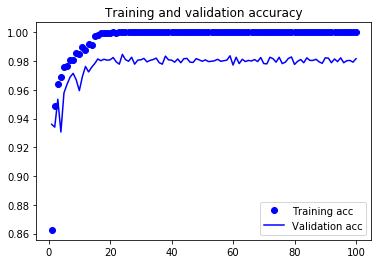

In [12]:
import matplotlib.pyplot as plt
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

acc = history.history['acc']
val_acc =  history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.show()

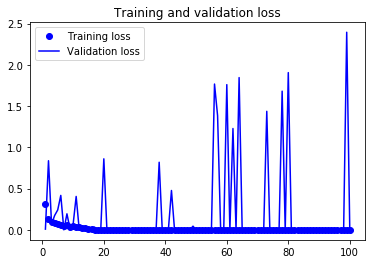

In [13]:
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()